In [1]:
from src.skeleton import BaseModel

In [2]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import torch

In [3]:
mnist_train_dataset = MNIST('./datasets', download=True, train=True, transform=transforms.ToTensor())
mnist_test_dataset = MNIST('./datasets', download=True, train=False, transform=transforms.ToTensor())
print(len(mnist_train_dataset), len(mnist_test_dataset))

60000 10000


In [4]:
#print(mnist_train_dataset)
#print(mnist_train_dataset.targets.shape)
#print(mnist_train_dataset.data.shape)
positive_set_train = mnist_train_dataset.data[mnist_train_dataset.targets==0]
positive_set_test = mnist_test_dataset.data[mnist_test_dataset.targets==0]
negative_set_test = mnist_test_dataset.data[mnist_test_dataset.targets!=0][:positive_set_test.shape[0]]
print(positive_set_train.shape, positive_set_test.shape,negative_set_test.shape)

torch.Size([5923, 28, 28]) torch.Size([980, 28, 28]) torch.Size([980, 28, 28])


In [5]:
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import numpy as np
class MNIST_Anomaly(Dataset):
    def __init__(self, dataset, y):
        self.dataset = dataset
        self.y = y
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self, index):
        X = self.dataset[index]
        y = self.y[index]
        return X,y,True
    
dataset_train = MNIST_Anomaly(positive_set_train, [0]*len(positive_set_train))
dataset_p_test = MNIST_Anomaly(positive_set_test, [0]*len(positive_set_test))
dataset_n_test = MNIST_Anomaly(negative_set_test, mnist_test_dataset.targets[mnist_test_dataset.targets!=0])
dataset_test = ConcatDataset([dataset_p_test, dataset_n_test])
print(len(dataset_train), len(dataset_p_test), len(dataset_n_test), len(dataset_test))

5923 980 980 1960


Positive samples


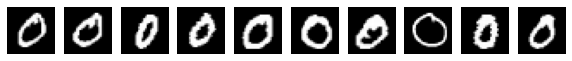

Negative samples


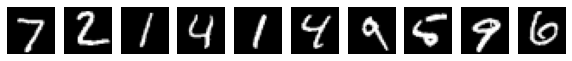

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,1))
print('Positive samples')
for i in range(10):
    ax = plt.subplot(1,10,i+1)
    ax.imshow(dataset_train[i][0], cmap=plt.get_cmap('gray'))
    ax.axis('off')
plt.show()

plt.figure(figsize=(10,1))
print('Negative samples')
for i in range(10):
    ax = plt.subplot(1,10,i+1)
    ax.imshow(dataset_n_test[i][0], cmap=plt.get_cmap('gray'))
    ax.axis('off')
plt.show()

In [7]:
BATCH = 256
EPOCH = 100
LR = 1e-3

In [8]:
train_loader = DataLoader(dataset_train, batch_size=BATCH, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=BATCH)

In [9]:
import torch.nn as nn
class MyModel(BaseModel):
    def __init__(self, in_dim, shift=0.0, scale=1.0, model_name='my_model'):
        super().__init__(model_name=model_name)
        self.enc1 = nn.Linear(in_dim, 256)
        self.enc2 = nn.Linear(256,128)
        self.enc3 = nn.Linear(128,64)
        self.dec1 = nn.Linear(64,128)
        self.dec2 = nn.Linear(128,256)
        self.dec3 = nn.Linear(256, in_dim)
        self.relu = nn.ReLU()
        self.shift = shift
        self.scale = scale
    def forward(self, batch, label=None, mask=None):
        x = self.enc1(batch)
        x = self.relu(x)
        x = self.enc2(x)
        x = self.relu(x)
        x = self.enc3(x)
        x = self.relu(x)
        x = self.dec1(x)
        x = self.relu(x)
        x = self.dec2(x)
        x = self.relu(x)
        x = self.dec3(x)
        return x
    def preprocess(self, batch, label=None, mask=None):
        batch = (batch-self.shift) / self.scale
        return batch.view(batch.size(0),-1)
    def criterion(self, pred=None, batch=None, label=None, mask=None):
        return nn.MSELoss()(pred, batch)


In [10]:
model = MyModel(28*28, shift=positive_set_train.min(), scale=(positive_set_train.max()-positive_set_train.min()+1e-10))
model.cuda()

MyModel(
  (enc1): Linear(in_features=784, out_features=256, bias=True)
  (enc2): Linear(in_features=256, out_features=128, bias=True)
  (enc3): Linear(in_features=128, out_features=64, bias=True)
  (dec1): Linear(in_features=64, out_features=128, bias=True)
  (dec2): Linear(in_features=128, out_features=256, bias=True)
  (dec3): Linear(in_features=256, out_features=784, bias=True)
  (relu): ReLU()
)

In [11]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), LR)

In [12]:
model.train_model(train_loader, test_loader, EPOCH, optimizer, report_intv=10)

(0.36s) [Epoch 1]
	Train Loss : 9.0380e-02	Train Score : 0.0000
	Eval Loss : 6.8568e-02	Eval Score : 0.0000
(0.07s) [Epoch 11]
	Train Loss : 2.3381e-02	Train Score : 0.0000
	Eval Loss : 3.8933e-02	Eval Score : 0.0000
(0.08s) [Epoch 21]
	Train Loss : 1.6834e-02	Train Score : 0.0000
	Eval Loss : 3.2679e-02	Eval Score : 0.0000
(0.07s) [Epoch 31]
	Train Loss : 1.4273e-02	Train Score : 0.0000
	Eval Loss : 2.9876e-02	Eval Score : 0.0000
(0.07s) [Epoch 41]
	Train Loss : 1.3068e-02	Train Score : 0.0000
	Eval Loss : 2.8011e-02	Eval Score : 0.0000
(0.07s) [Epoch 51]
	Train Loss : 1.1924e-02	Train Score : 0.0000
	Eval Loss : 2.5909e-02	Eval Score : 0.0000
(0.07s) [Epoch 61]
	Train Loss : 1.1222e-02	Train Score : 0.0000
	Eval Loss : 2.4566e-02	Eval Score : 0.0000
(0.07s) [Epoch 71]
	Train Loss : 1.0604e-02	Train Score : 0.0000
	Eval Loss : 2.3520e-02	Eval Score : 0.0000
(0.07s) [Epoch 81]
	Train Loss : 1.0141e-02	Train Score : 0.0000
	Eval Loss : 2.2899e-02	Eval Score : 0.0000
(0.07s) [Epoch 91]
	

In [13]:
def run_inference(model, dataloader):
    model.eval()
    losses = []
    ys = []
    criterion = nn.MSELoss(reduction='none')
    for batch, label, mask in dataloader:
        batch = batch.cuda().to(dtype=torch.float)
        batch = model.preprocess(batch)
        with torch.no_grad():
            pred = model.forward(batch)
        loss = criterion(pred, batch).view(pred.shape[0],-1).mean(-1)
        losses.append(loss.cpu())
        ys.append(label)
    losses = torch.cat(losses, 0)
    ys = torch.cat(ys, 0)
    return losses, ys

def find_thres(losses, sigma=3):
    mean = losses.mean()
    std = losses.std()
    thres = mean+std*sigma
    return thres.item()


In [14]:
losses_train, _ = run_inference(model, train_loader)

print(losses_train.shape)

torch.Size([5923])


In [15]:
thres = find_thres(losses_train, sigma=3)
print(thres)

0.01974434033036232


In [16]:
losses, ys = run_inference(model, test_loader)

losses_p = losses[ys==0]
losses_n = losses[ys!=0]
print(losses_p.shape, losses_n.shape)

torch.Size([980]) torch.Size([980])


In [17]:
TP = len(losses_p[losses_p<thres])
FN = len(losses_p[losses_p>thres])
TN = len(losses_n[losses_n>thres])
FP = len(losses_n[losses_n<thres])
print('TP : %5d,\tFP : %5d'%(TP, FP))
print('FN : %5d,\tTN : %5d'%(FN ,TN))
print('Accuracy : %.2f,\tPrecision : %.2f,\tRecall : %.2f'%((TP+TN)/(TP+TN+FP+FN), (TP)/(TP+FP+1e-10), (TP)/(TP+FN)))

TP :   955,	FP :    28
FN :    25,	TN :   952
Accuracy : 0.97,	Precision : 0.97,	Recall : 0.97


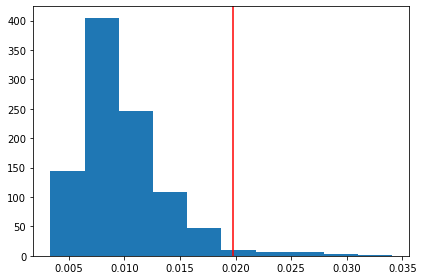

[Normal]
Max : 0.0341	Mean : 0.0099	Min : 0.0034



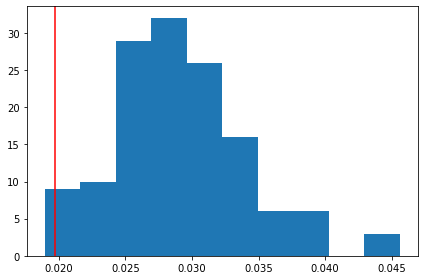

[Anomaly 1]
Max : 0.0456	Mean : 0.0290	Min : 0.0189



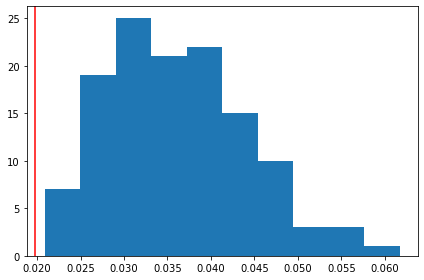

[Anomaly 2]
Max : 0.0617	Mean : 0.0363	Min : 0.0209



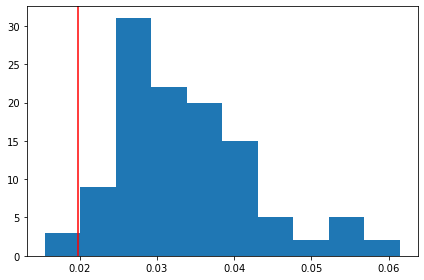

[Anomaly 3]
Max : 0.0615	Mean : 0.0337	Min : 0.0155



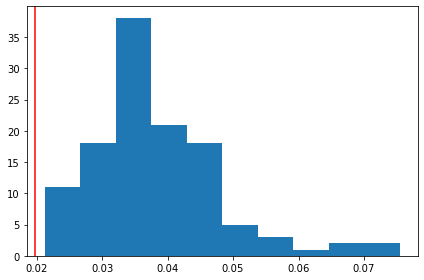

[Anomaly 4]
Max : 0.0755	Mean : 0.0382	Min : 0.0212



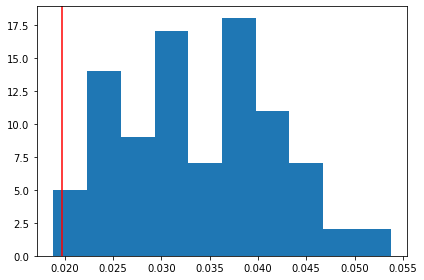

[Anomaly 5]
Max : 0.0537	Mean : 0.0338	Min : 0.0188



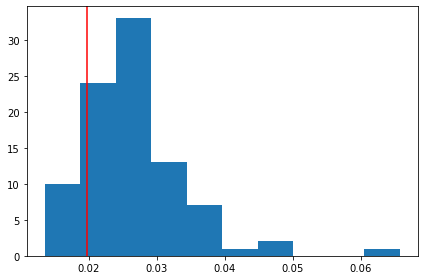

[Anomaly 6]
Max : 0.0657	Mean : 0.0264	Min : 0.0135



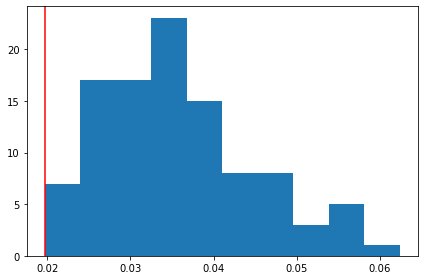

[Anomaly 7]
Max : 0.0624	Mean : 0.0355	Min : 0.0197



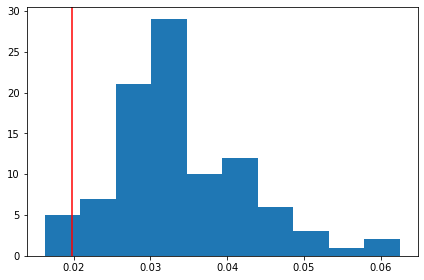

[Anomaly 8]
Max : 0.0625	Mean : 0.0339	Min : 0.0162



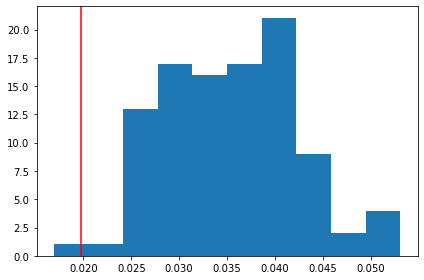

[Anomaly 9]
Max : 0.0531	Mean : 0.0355	Min : 0.0169



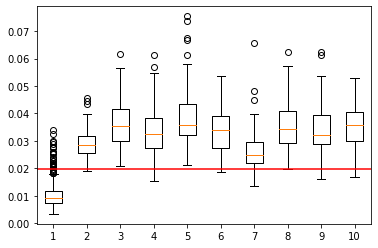

In [18]:
import matplotlib.pyplot as plt
maxes=[]
means=[]
mins=[]
lois = [losses[ys==i] for i in range(10)]
for i in range(10):
    loi = lois[i]
    counts, bins = np.histogram(loi)
    plt.hist(bins[:-1], bins, weights=counts)
    plt.axvline(thres, c='r')
    plt.tight_layout()
    plt.show()
    if i==0:
        print('[Normal]')
    else:
        print('[Anomaly %d]'%i)
    maxes.append(loi.max())
    means.append(loi.mean())
    mins.append(loi.min())
    print('Max : %.4f\tMean : %.4f\tMin : %.4f\n'%(maxes[-1], means[-1], mins[-1]))
    
plt.boxplot(lois)
plt.axhline(thres, c='r')
plt.show()

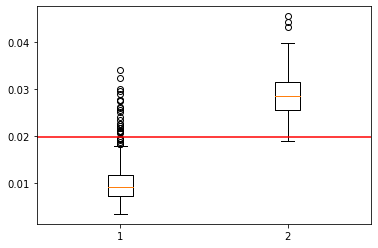

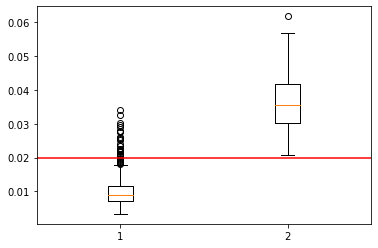

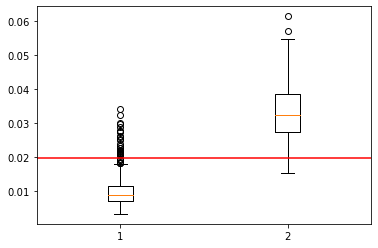

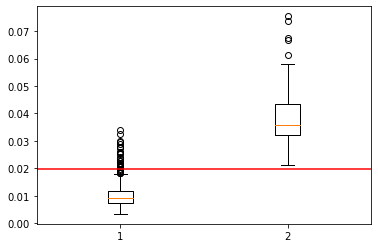

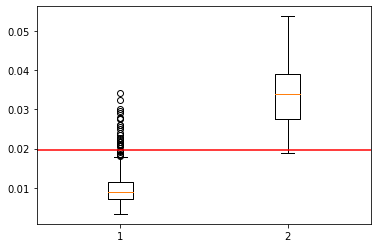

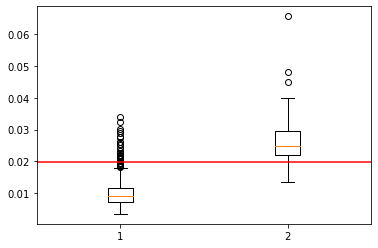

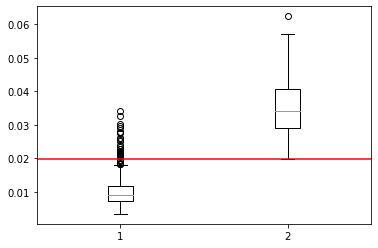

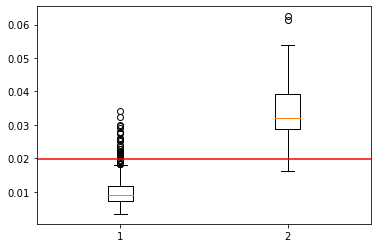

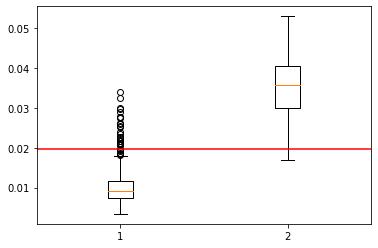

In [19]:
for i in range(9):
    plt.boxplot([lois[0],lois[i+1]])
    plt.axhline(thres, c='r')
    plt.show()

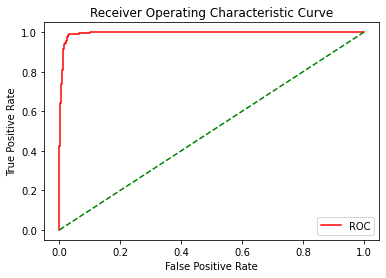

Thres : 1.0755e+00,	FPR : 0.0000,	TPR : 0.0000
Thres : 7.5472e-02,	FPR : 0.0000,	TPR : 0.0010
Thres : 3.4109e-02,	FPR : 0.0000,	TPR : 0.4245
Thres : 3.4090e-02,	FPR : 0.0010,	TPR : 0.4245
Thres : 3.2501e-02,	FPR : 0.0010,	TPR : 0.4908
Thres : 3.2479e-02,	FPR : 0.0020,	TPR : 0.4908
Thres : 3.2298e-02,	FPR : 0.0020,	TPR : 0.5031
Thres : 3.2295e-02,	FPR : 0.0020,	TPR : 0.5051
Thres : 3.0098e-02,	FPR : 0.0020,	TPR : 0.6092
Thres : 3.0082e-02,	FPR : 0.0031,	TPR : 0.6092
Thres : 2.9682e-02,	FPR : 0.0031,	TPR : 0.6418
Thres : 2.9654e-02,	FPR : 0.0041,	TPR : 0.6418
Thres : 2.9032e-02,	FPR : 0.0041,	TPR : 0.6673
Thres : 2.9032e-02,	FPR : 0.0051,	TPR : 0.6673
Thres : 2.7748e-02,	FPR : 0.0051,	TPR : 0.7367
Thres : 2.7712e-02,	FPR : 0.0071,	TPR : 0.7367
Thres : 2.7553e-02,	FPR : 0.0071,	TPR : 0.7429
Thres : 2.7549e-02,	FPR : 0.0082,	TPR : 0.7429
Thres : 2.6197e-02,	FPR : 0.0082,	TPR : 0.8020
Thres : 2.6110e-02,	FPR : 0.0092,	TPR : 0.8020
Thres : 2.5913e-02,	FPR : 0.0092,	TPR : 0.8092
Thres : 2.590

In [20]:
from sklearn.metrics import roc_curve


fpr, tpr, thresholds = roc_curve([0]*losses[ys==0].shape[0]+[1]*losses[ys!=0].shape[0], losses.flatten())
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()
plot_roc_curve(fpr,tpr)
for i in range(len(fpr)):
    print("Thres : %.4e,\tFPR : %.4f,\tTPR : %.4f"%(thresholds[i],fpr[i],tpr[i]))
#print(fpr,tpr,thres)

In [21]:
THRESHOLD = 1.3666e-02
TP = len(losses_p[losses_p<THRESHOLD])
FN = len(losses_p[losses_p>THRESHOLD])
TN = len(losses_n[losses_n>THRESHOLD])
FP = len(losses_n[losses_n<THRESHOLD])
print('TP : %5d,\tFP : %5d'%(TP, FP))
print('FN : %5d,\tTN : %5d'%(FN ,TN))
print('Accuracy : %.2f,\tPrecision : %.2f,\tRecall : %.2f'%((TP+TN)/(TP+TN+FP+FN), (TP)/(TP+FP), (TP)/(TP+FN)))

TP :   860,	FP :     1
FN :   120,	TN :   979
Accuracy : 0.94,	Precision : 1.00,	Recall : 0.88
